In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 100
L_f = 1

In [3]:
# Objective function.
def f(x):
    x = np.array(x)
    s = np.sum((x[:-1] - x[1:])**2)
    return (L_f/8)*(x[0]**2 + s + x[-1]**2) - (L_f/4)*x[0]
   
# Exact Gradient of the objective function   
def grad_f(x):
    df_x1 = (L_f/4)*(2*x[0]-x[1] - 1) 
    df_xi = [(L_f/4)*(-x[i-1] + 2*x[i] - x[i+1]) for i in range(1,n-1)]
    df_xn = (L_f/4)*(2*x[-1] - x[n-2])
    return np.array([df_x1] + df_xi + [df_xn]) 

f_star = (-n*L_f)/(8*(n+1))
x_star = np.array([1-((i+1)/(n+1))  for i in range(n)])

In [4]:
# Relative noisy gradient
def noisy_gradf(x, eps):
    exact_grad = grad_f(x)
    return np.multiply(1-eps, exact_grad)

In [5]:
# AIM. p fixed
def adaptive_L_interm_grad_inex(x0, K, p, Ls, epsilon, cons_inex):
    L = Ls 
    zk = x0
    xk = x0 
    delta0 = (epsilon**2)*((np.linalg.norm(noisy_gradf(x0, epsilon)))**2) / cons_inex
    grad_xk = noisy_gradf(xk, epsilon)
    trig = 0
    while trig<1:
        ak = 1/L
        yk = xk - np.multiply(ak, noisy_gradf(xk, epsilon))
        if (f(yk) > f(xk) + grad_xk.dot(yk-xk) + (L/2)*np.linalg.norm(yk-xk) + delta0):
            L = L*2
            trig = 0
        else:
            trig = 1    
    ak = 1/L 
    Ak = ak 
    Bk = Ak     
    R0_squre = np.linalg.norm(x0 - x_star)**2      
    FxkArray = [f(yk)]
    e_0 = (8*L_f*R0_squre)/(2**p)
    Estimates1 = [e_0]
    list_deltas = [delta0]
    Estimates2 = []
    Bi_deltai = Bk*delta0
    sums = np.multiply(ak, noisy_gradf(x0, epsilon))
    k = 0
    while(k < K):
        k += 1
        i = 0                       
        while True:                 
            L1 = 2**(i)*L
            h = ((i+2*p)/(2*p))**(p-1)
            ak = h/L1               
            Bk = ak*h              
            g = 1/h
            xk = g*zk + (1-g)*yk
            deltak = (epsilon**2)*((np.linalg.norm(noisy_gradf(xk, epsilon)))**2) / cons_inex
            grad_xk = noisy_gradf(xk, epsilon)
            zk = xk - np.sum([sums, np.multiply(ak, grad_xk)], axis=0)
            wk = g*zk + (1-g)*yk   
            i += 1
            if not (f(wk) > f(xk) + grad_xk.dot(wk-xk) + (L1/2)*(np.linalg.norm(wk-xk)**2) + deltak):
                break        
        L = L1
        Ak = Ak + ak
        yk = ((Ak - Bk) * yk + Bk * wk) / Ak
        sums = np.sum([sums, np.multiply(ak, grad_xk)], axis=0)   
        FxkArray.append(f(yk))
        list_deltas.append(deltak)
        Estimate1_k = 8*L_f*R0_squre/((k+2)**p) + 2*np.max(list_deltas)*(k**(p-1))
        Estimates1.append(Estimate1_k)
        Bi_deltai += Bk*deltak
        Estimate2_k = (0.5*R0_squre + Bi_deltai )/Ak
        Estimates2.append(Estimate2_k)                                        
    return FxkArray, Estimates1#, Estimates2

In [6]:
# AIM with variable p
def adaptive_LP_interm_grad_inex(x0, K, Ls, epsilon, cons_inex):
    L = Ls 
    zk = x0
    xk = x0 
    delta0 = (epsilon**2)*((np.linalg.norm(noisy_gradf(x0, epsilon)))**2) / cons_inex
    grad_xk = noisy_gradf(xk, epsilon)
    trig = 0
    while trig < 1:
        ak = 1/L
        yk = xk - np.multiply(ak, noisy_gradf(xk, epsilon))
        if (f(yk) > f(xk) + grad_xk.dot(yk - xk) + (L/2)*np.linalg.norm(yk - xk) + delta0):
            L = L*2
            trig = 0
        else:
            trig = 1
    ak = 1/L 
    Ak = ak  
    Bk = Ak     
    R0_squre = np.linalg.norm(x0 - x_star)**2   
    FxkArray = [f(yk)]               
    k = 0 
    p = 2
    list_deltas = [delta0]
    e_0 = (8*L_f*R0_squre)/(2**p)  
    Estimate_k = e_0
    Estimates1 = []             
    sums = np.multiply(ak, noisy_gradf(x0, epsilon))   
    while(k < K):
        i = 0                       
        while True:                 
            L1 = 2**(i)*L
            h = ((i + 2*p)/(2*p))**(p - 1)
            ak = h/L1               
            Bk = ak*h             
            g = 1/h
            xk = g*zk + (1 - g)*yk
            deltak = (epsilon**2)*((np.linalg.norm(noisy_gradf(xk, epsilon)))**2) / cons_inex
            grad_xk = noisy_gradf(xk, epsilon)
            zk = xk - np.sum([sums, np.multiply(ak, grad_xk)], axis=0)
            wk = g*zk + (1 - g)*yk      
            i += 1
            if not (f(wk) > f(xk) + grad_xk.dot(wk-xk) + (L1/2)*(np.linalg.norm(wk - xk)**2) + deltak):
                break          
        L = L1
        Ak = Ak + ak
        yk = ((Ak - Bk) * yk + Bk * wk) / Ak
        sums = np.sum([sums, np.multiply(ak, grad_xk)], axis=0)   
        FxkArray.append(f(yk))
        list_deltas.append(deltak)
        Estimate1_k = (8*L_f*R0_squre/((k + 2)**p)) + 2*np.max(list_deltas)*(k**(p-1))
        if (Estimate1_k - Estimate_k > 0 and p >= 1):
            p -= 0.01          
        else:
            Estimate_k = Estimate1_k
            Estimates1.append(Estimate_k)   
        k += 1                                         
    return FxkArray, Estimates1

In [7]:
x0 = np.array([0.5]*n)
K = 50000
Ls = 0.1
epsilon = 0.99
cons_inex = 1000

In [9]:
### results AIM
res_adptive_L_2_0 = adaptive_L_interm_grad_inex(x0, K, 2,   Ls, epsilon, cons_inex) # fixed p = 2
res_adptive_L_1_9 = adaptive_L_interm_grad_inex(x0, K, 1.9, Ls, epsilon, cons_inex) # fixed p = 1.9
res_adptive_L_1_8 = adaptive_L_interm_grad_inex(x0, K, 1.8, Ls, epsilon, cons_inex) # fixed p = 1.8
res_adptive_L_1_7 = adaptive_L_interm_grad_inex(x0, K, 1.7, Ls, epsilon, cons_inex) # fixed p = 1.7
res_adptive_L_1_6 = adaptive_L_interm_grad_inex(x0, K, 1.6, Ls, epsilon, cons_inex) # fixed p = 1.6
res_adptive_L_1_5 = adaptive_L_interm_grad_inex(x0, K, 1.5, Ls, epsilon, cons_inex) # fixed p = 1.5
res_adptive_L_1_4 = adaptive_L_interm_grad_inex(x0, K, 1.4, Ls, epsilon, cons_inex) # fixed p = 1.4
res_adptive_L_1_3 = adaptive_L_interm_grad_inex(x0, K, 1.3, Ls, epsilon, cons_inex) # fixed p = 1.3
res_adptive_L_1_2 = adaptive_L_interm_grad_inex(x0, K, 1.2, Ls, epsilon, cons_inex) # fixed p = 1.2
res_adptive_L_1_1 = adaptive_L_interm_grad_inex(x0, K, 1.1, Ls, epsilon, cons_inex) # fixed p = 1.1
res_adptive_L_1_0 = adaptive_L_interm_grad_inex(x0, K, 1,   Ls, epsilon, cons_inex) # fixed p = 1

In [10]:
### results AIM with variable p
res_adap_LP = adaptive_LP_interm_grad_inex(x0, K, Ls, epsilon, cons_inex)  # non-fixed p from 2 to 1

In [11]:
y_adptive_L_2_0 = [(value_f - f_star) for value_f in res_adptive_L_2_0[0] ] # fixed p = 2
y_adptive_L_1_9 = [(value_f - f_star) for value_f in res_adptive_L_1_9[0] ] # fixed p = 1.9
y_adptive_L_1_8 = [(value_f - f_star) for value_f in res_adptive_L_1_8[0] ] # fixed p = 1.8
y_adptive_L_1_7 = [(value_f - f_star) for value_f in res_adptive_L_1_7[0] ] # fixed p = 1.7
y_adptive_L_1_6 = [(value_f - f_star) for value_f in res_adptive_L_1_6[0] ] # fixed p = 1.6
y_adptive_L_1_5 = [(value_f - f_star) for value_f in res_adptive_L_1_5[0] ] # fixed p = 1.5
y_adptive_L_1_4 = [(value_f - f_star) for value_f in res_adptive_L_1_4[0] ] # fixed p = 1.4
y_adptive_L_1_3 = [(value_f - f_star) for value_f in res_adptive_L_1_3[0] ] # fixed p = 1.3
y_adptive_L_1_2 = [(value_f - f_star) for value_f in res_adptive_L_1_2[0] ] # fixed p = 1.2
y_adptive_L_1_1 = [(value_f - f_star) for value_f in res_adptive_L_1_1[0] ] # fixed p = 1.1
y_adptive_L_1_0 = [(value_f - f_star) for value_f in res_adptive_L_1_0[0] ] # fixed p = 1

y_adaptive_LP = [(value_f - f_star) for value_f in res_adap_LP[0] ]     # non-fixed p from 2 to 1

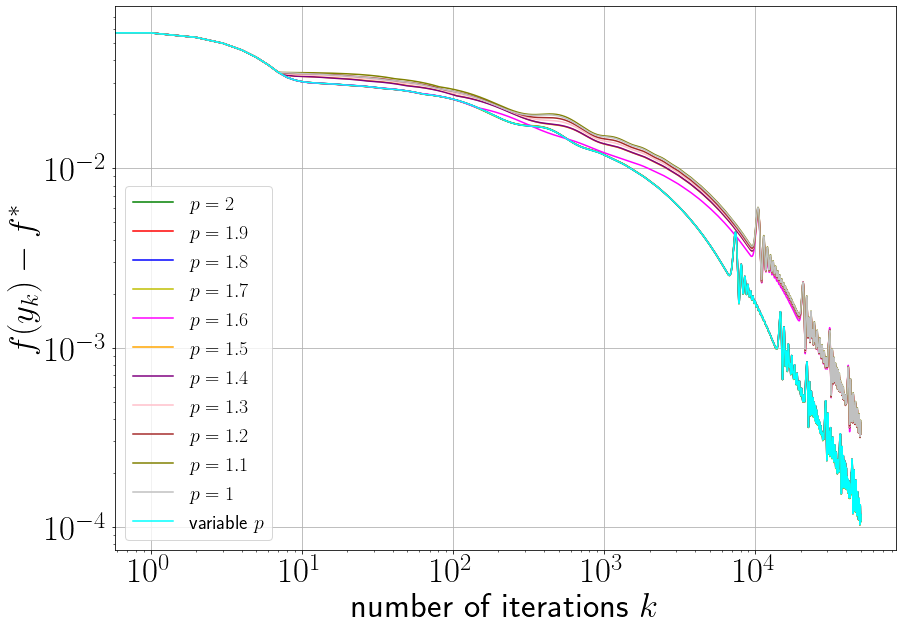

In [12]:
plt.rc('text', usetex=True)
plt.figure(figsize=(14, 10))
fontsize=20

plt.plot(range(len(y_adptive_L_2_0)), y_adptive_L_2_0 ,'g')
plt.plot(range(len(y_adptive_L_1_9)), y_adptive_L_1_9 ,'r')
plt.plot(range(len(y_adptive_L_1_8)), y_adptive_L_1_8 ,'b')
plt.plot(range(len(y_adptive_L_1_7)), y_adptive_L_1_7 ,'y')
plt.plot(range(len(y_adptive_L_1_6)), y_adptive_L_1_6 ,'magenta')
plt.plot(range(len(y_adptive_L_1_5)), y_adptive_L_1_5 ,'orange')
plt.plot(range(len(y_adptive_L_1_4)), y_adptive_L_1_4 ,'purple')
plt.plot(range(len(y_adptive_L_1_3)), y_adptive_L_1_3 ,'pink')
plt.plot(range(len(y_adptive_L_1_2)), y_adptive_L_1_2 ,'brown')
plt.plot(range(len(y_adptive_L_1_1)), y_adptive_L_1_1 ,'olive')
plt.plot(range(len(y_adptive_L_1_0)), y_adptive_L_1_0 ,'silver')

plt.plot(range(len(y_adaptive_LP)), y_adaptive_LP ,'cyan')

plt.grid(True)
plt.xlabel('number of iterations $k$' , fontsize=35)
plt.ylabel('$f(y_k)-f^{*}$' , fontsize=35)
plt.xticks(fontsize=35)
_ = plt.yticks(fontsize=35)

plt.legend(['$p=2$', '$p=1.9$', '$p=1.8$', '$p=1.7$','$p=1.6$', '$p=1.5$','$p=1.4$', '$p=1.3$','$p=1.2$', '$p=1.1$',
            '$p=1$', 'variable $p$' ], fontsize=fontsize) 


#plt.title('relative error, $\hat{\epsilon}=0.9$' , fontsize=fontsize)
plt.yscale('log')
plt.xscale('log')
plt.savefig('values_f_adaptive.pdf')
plt.show()

In [13]:
estim_adaptive_L_2_0 = res_adptive_L_2_0[1]
estim_adaptive_L_1_9 = res_adptive_L_1_9[1]
estim_adaptive_L_1_8 = res_adptive_L_1_8[1]
estim_adaptive_L_1_7 = res_adptive_L_1_7[1]
estim_adaptive_L_1_6 = res_adptive_L_1_6[1]
estim_adaptive_L_1_5 = res_adptive_L_1_5[1]
estim_adaptive_L_1_4 = res_adptive_L_1_4[1]
estim_adaptive_L_1_3 = res_adptive_L_1_3[1]
estim_adaptive_L_1_2 = res_adptive_L_1_2[1]
estim_adaptive_L_1_1 = res_adptive_L_1_1[1]
estim_adaptive_L_1_0 = res_adptive_L_1_0[1]

estim_adaptive_LP = res_adap_LP[1]

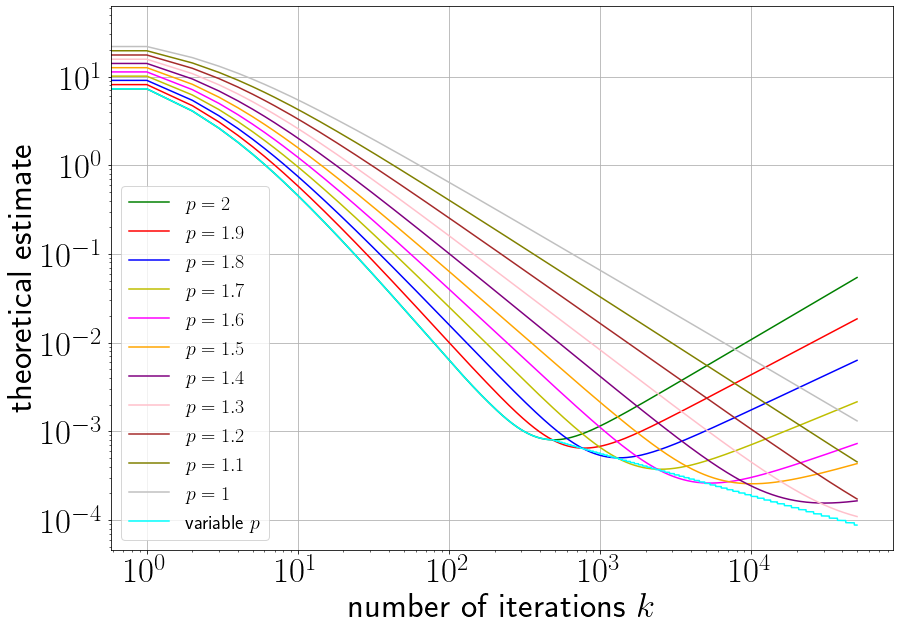

In [14]:
plt.rc('text', usetex=True)
plt.figure(figsize=(14, 10))
fontsize=20

plt.plot(range(len(estim_adaptive_L_2_0)), estim_adaptive_L_2_0 ,'g')
plt.plot(range(len(estim_adaptive_L_1_9)), estim_adaptive_L_1_9 ,'r')
plt.plot(range(len(estim_adaptive_L_1_8)), estim_adaptive_L_1_8 ,'b')
plt.plot(range(len(estim_adaptive_L_1_7)), estim_adaptive_L_1_7 ,'y')
plt.plot(range(len(estim_adaptive_L_1_6)), estim_adaptive_L_1_6 ,'magenta')
plt.plot(range(len(estim_adaptive_L_1_5)), estim_adaptive_L_1_5 ,'orange')
plt.plot(range(len(estim_adaptive_L_1_4)), estim_adaptive_L_1_4 ,'purple')
plt.plot(range(len(estim_adaptive_L_1_3)), estim_adaptive_L_1_3 ,'pink')
plt.plot(range(len(estim_adaptive_L_1_2)), estim_adaptive_L_1_2 ,'brown')
plt.plot(range(len(estim_adaptive_L_1_1)), estim_adaptive_L_1_1 ,'olive')
plt.plot(range(len(estim_adaptive_L_1_0)), estim_adaptive_L_1_0 ,'silver')

plt.plot(range(len(estim_adaptive_LP)), estim_adaptive_LP , 'cyan')

plt.grid(True)
plt.xlabel('number of iterations $k$' , fontsize=35)
plt.ylabel('theoretical estimate' , fontsize=35)
plt.xticks(fontsize=35)
_ = plt.yticks(fontsize=35)

plt.legend(['$p=2$', '$p=1.9$', '$p=1.8$', '$p=1.7$','$p=1.6$', '$p=1.5$','$p=1.4$', '$p=1.3$','$p=1.2$', '$p=1.1$',
            '$p=1$', 'variable $p$' ], fontsize=fontsize) 

#plt.title('relative error, $\hat{\epsilon}=0.9$' , fontsize=fontsize)
plt.yscale('log')
plt.xscale('log')
plt.savefig('estimate2_adaptive.pdf')
plt.show()